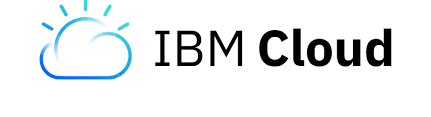

# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

In [1]:
%%capture
pip install -U pip

In [2]:
%%capture
pip install pyLDAvis

In [3]:
%%capture
pip install ../data/en_core_web_sm-2.3.1.tar.gz --user

In [1]:
##IMPORTANT: Please restart the Kernel after running the above 3 cells

In [2]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

try:
    import pyLDAvis
    import pyLDAvis.sklearn
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
plt.style.use('seaborn')
%matplotlib inline

DATA_DIR = os.path.join("..","data")

## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week and being the diligent data scientist that you are your plan is to build a topic modeling pipeline that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Even before receiving the first comment, we want to start building our Pipeline using a proxy dataset. In this study Case we will work with a dataset publicly available dataset of movie reviews.

* [Here](http://www.nltk.org/nltk_data) is the web page that references all the public dataset that NLTK provide. In this Study Case we will work with the 'Sentiment Polarity Dataset Version 2.0' dataset. (The dataset has already been downloaded and is in the data folder of the working directory)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [3]:
filename = os.path.join(DATA_DIR, 'movie_reviews.csv')
df = pd.read_csv(filename)
X = df['review'].tolist()
print(X[4])

b"kolya is one of the richest films i've seen in some time . \nzdenek sverak plays a confirmed old bachelor ( who's likely to remain so ) , who finds his life as a czech cellist increasingly impacted by the five-year old boy that he's taking care of . \nthough it ends rather abruptly-- and i'm whining , 'cause i wanted to spend more time with these characters-- the acting , writing , and production values are as high as , if not higher than , comparable american dramas . \nthis father-and-son delight-- sverak also wrote the script , while his son , jan , directed-- won a golden globe for best foreign language film and , a couple days after i saw it , walked away an oscar . \nin czech and russian , with english subtitles . \n"


### QUESTION 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  The goal of this case study is to ensure that you are comfortable with natural language processing pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. 

If you prefer to use NLTK then you could use a simple lemmatizer like the WordLemmatizer.

In [4]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo", "film", "movie", "make"])

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en_core_web_sm')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)
    doc = doc.replace('\\n','')
    doc = doc.replace('\\t','')

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub(r"\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

Loading English Module...
pron fool people time people time pron fool people time abraham lincoln

pron can fool some of the people all of the time and all of the people some of the time but pron can not fool all of the people all of the time abraham lincoln


In [5]:
## YOUR CODE HERE

## Preprocess all the reviews of the corpus with the lemmatize_document() function to create a list of cleaned reviews.

## Applying the lemmatize_document() function to all the documents of the corpus takes several minutes. 
## In order to save you some time we preprocessed the texts with the line of code commented bellow and saved
## the processed documents in a .txt file. You can either re-preprocess the text by uncommenting the lines above
## or you can directly read the processed_text.txt file as shown bellow.

# from tqdm import tqdm
# tqdm.pandas()
# processed = df.progress_apply(lambda x : lemmatize_document(x['review'], STOPLIST), axis=1).tolist()

processed = []
with open(os.path.join(DATA_DIR, 'processed_text.txt'), 'r') as f :
    for line in f:
        processed.append(line)


print("processing done.")

processing done.


### QUESTION 2

Use the CountVectorizer from sklearn to vectorize the documents.

Additional resources:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 500.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [6]:
## YOUR CODE HERE

max_features = 500

# Create a CountVectorizer object
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=max_features,
                                stop_words='english')

# Fit and transform this object to the processed reviews
tf = tf_vectorizer.fit_transform(processed)
print("ready")

ready


In [11]:
processed

['barnold schwarzenegger icon action enthusiast late 80 lately pron sloppy oneliner bad pron hard seeing arnold mr freeze batman robin especially pron say ton ice joke hey pron 15 million pron matter pron arnold sign expensive blockbuster compare like terminator series true lie eraser dark thriller devil gabriel byrne come earth impregnate woman robin tunney happen 1000 year basically destroy world apparently god choose man man jericho cane arnold pron help trusty sidekick kevin pollack pron stop let devil world actually absurd pron fit right dogma yes weak pron blockbuster right sleepy hollow pron world look like star definitely like arnold pron just type pron pron sure pron pron chuckle pron known oneliner pron confused pron character pron understandable especially ending change accord source aside form pron walk pron like pron past pron sorry say arnold maybe end pron action day speaking action pron hardly explosion fight devil place explode arnold kick devil butt ending change pron

### QUESTION 3

Fit a LDA model to the corpus. For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```


* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [12]:
## YOUR CODE HERE
n_topics = 10

# Create an LDA object
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

# Fit the model to the bag of word we created earlier
lda_model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [13]:
## YOUR CODE HERE
pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, R=20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.106227  0.003539       1        1  83.799368
7      0.085819 -0.009089       2        1  10.216954
1      0.112588  0.081812       3        1   4.437520
0     -0.235791 -0.369282       4        1   0.872043
5     -0.419451  0.237814       5        1   0.361893
9      0.070150  0.011021       6        1   0.062444
3      0.070136  0.011017       7        1   0.062444
4      0.070109  0.011055       8        1   0.062444
2      0.070105  0.011057       9        1   0.062444
6      0.070107  0.011056      10        1   0.062444, topic_info=    Category          Freq        Term         Total  loglift  logprob
334  Default  71911.000000        pron  71911.000000  20.0000  20.0000
371  Default   2635.000000       scene   2635.000000  19.0000  19.0000
247  Default   3766.000000        like   3766.000000  18.0000  18.0000
176  Default   3433.000000        good   3433.000000  17.0000  17.0000
225  Default   2871.000000        just   2871.000000  16.0000  16.0000
..       ...           ...         ...           ...      ...      ...
429  Topic10      0.396978     support    279.996126   0.8200  -6.2143
179  Topic10      0.396978        grow    276.818630   0.8314  -6.2143
95   Topic10      0.396977     despite    344.609041   0.6124  -6.2143
457  Topic10      0.396974  understand    224.376219   1.0414  -6.2144
96   Topic10      0.396973     develop    241.039420   0.9698  -6.2144

[396 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3         1  0.534565   action
3         2  0.192278   action
3         4  0.271012   action
5         1  0.982831  actress
5         2  0.004636  actress
...     ...       ...      ...
496       2  0.199725     year
496       3  0.105624     year
499       1  0.505414    young
499       2  0.126072    young
499       3  0.366960    young

[613 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 2, 1, 6, 10, 4, 5, 3, 7])

## QUESTION 5

Try different numbers of clusters until there is decent separation in the visualization

In [14]:
## YOUR CODE HERE

n_topics = 7
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)
lda_model.fit(tf)
lda_transformed = lda_model.transform(tf)
pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, R=20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.098991 -0.044500       1        1  29.300919
6      0.131576 -0.056794       2        1  27.107429
0      0.121283 -0.062808       3        1  24.031233
2      0.088091 -0.044579       4        1  13.046523
3      0.093074 -0.004150       5        1   5.441023
4     -0.112754  0.368295       6        1   0.770355
5     -0.420260 -0.155464       7        1   0.302517, topic_info=    Category          Freq      Term         Total  loglift  logprob
334  Default  72523.000000      pron  72523.000000  20.0000  20.0000
37   Default    557.000000     black    557.000000  19.0000  19.0000
39   Default    403.000000      book    403.000000  18.0000  18.0000
218  Default    360.000000      jack    360.000000  17.0000  17.0000
228  Default    697.000000      kill    697.000000  16.0000  16.0000
..       ...           ...       ...           ...      ...      ...
154   Topic7      0.220156     fight    481.017019  -1.8885  -8.3818
362   Topic7      0.185747     robin    205.737115  -1.2092  -8.5517
393   Topic7      0.193165    simple    286.484730  -1.5011  -8.5125
339   Topic7      0.200701  question    497.863327  -2.0155  -8.4743
369   Topic7      0.197883      save    486.792063  -2.0071  -8.4884

[257 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3         1  0.107218  action
3         2  0.101308  action
3         3  0.028704  action
3         4  0.678766  action
3         5  0.064162  action
...     ...       ...     ...
499       1  0.333019   young
499       2  0.027161   young
499       3  0.557393   young
499       4  0.007086   young
499       5  0.075579   young

[837 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 1, 3, 4, 5, 6])

The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## QUESTION 6

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

In [17]:
lda_model.components_.shape

(7, 500)

In [15]:
def get_top_words(model, feature_names, n_top_words):
    """
    Get the top words defining the different topics of the LDA model
    INPUT : the LDA model, the names of the features of the bag of word (these are the actual words in the vocabulary) 
    and the number of top words.
    RETURN : A dictionary where the keys are the topic's ID and the values are the lists of the n_top_words top words.
    
    """
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return top_words

Use the function to print the top k words for each topic

In [18]:
## YOUR CODE HERE

## set n_top_words
top_words = 15
## get the vectorizer's feature names
tf_feature_names = np.array(tf_vectorizer.get_feature_names())
## get the top words for each topic
top_words = get_top_words(lda_model, tf_feature_names, top_words)
all_top_words = np.array(list(set().union(*[v for v in top_words.values()])))

## print the topics and the top words of each topic
for key,vals in top_words.items():
    print(key, " ".join(vals))
print("total words: %s"%len(all_top_words))

0 pron life character love good like story performance man play family time year work young
1 pron character story scene like time just man good come way end new know play
2 pron action good plot play character scene like actor bad work role script cast director
3 pron alien effect special star ship war disney earth computer space year science good human
4 black lee studio white battle human fight group planet pron summer paul night death escape
5 jack vampire book comic james base hero kill john team style genre walk dark novel
6 pron like just bad good think know really time say thing character look scene people
total words: 76


## QUESTION (EXTRA CREDIT) 7

If you used `transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects this matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

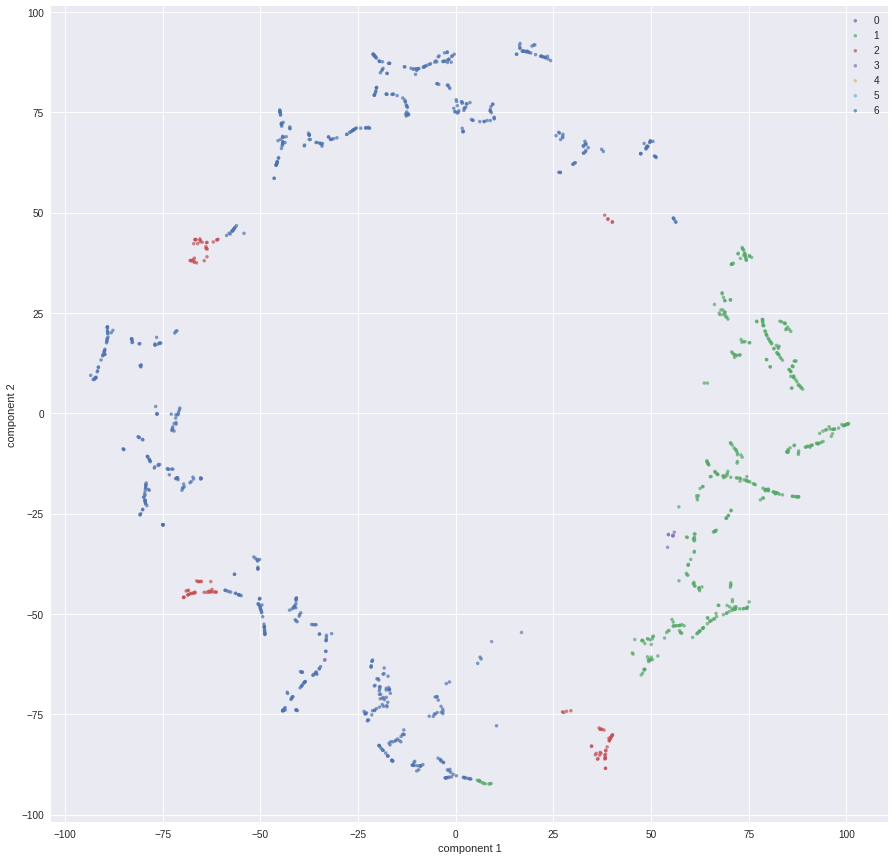

In [19]:
## YOUR CODE HERE

def make_plot(lda_mat):
    
    fig = plt.figure(figsize=(15,15), facecolor='white')
    ax = fig.add_subplot(111)
    
    tsne = TSNE(n_components=2, perplexity=10, init='pca')
    projected = tsne.fit_transform(lda_mat)
    
#     pca = PCA(n_components=2)
#     projected = pca.fit_transform(lda_mat)
    
    for class_num in np.arange(n_topics):
        topic_inds = np.where(lda_mat[:, class_num] > 0.5)[0]
        ax.scatter(projected[topic_inds, 0],
                   projected[topic_inds, 1], 
                   edgecolor='none', marker='.', alpha=0.7, label=str(class_num))

    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.legend()
    
    
make_plot(lda_transformed)